In [1]:
from matplotlib import pyplot as plt
import b2plot as bp
#plt.style.use('belle2_modern')

# basic setup of the notebook

import numpy as np

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)
from iminuit import cost, Minuit

For optimal usage set `plt.style.use('belle2')`
iminuit version: 2.15.2


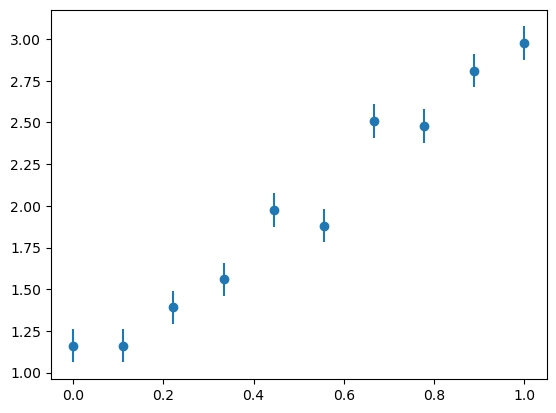

In [2]:
# our line model, unicode parameter names are supported :)
def line(x, α, β):
    return α + x * β


# generate random toy data with random offsets in y
np.random.seed(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1  # could also be an array
data_y = line(data_x, 1, 2) + data_yerr * np.random.randn(len(data_x))

# draw toy data
plt.errorbar(data_x, data_y, data_yerr, fmt="o");

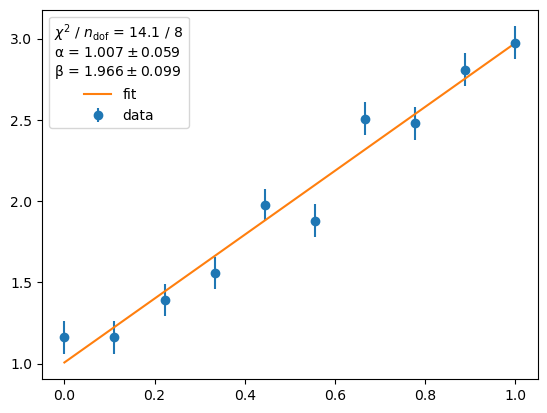

In [3]:
# iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
# We will revisit how to write this by hand in a later section.
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, α=0, β=0)  # starting values for α and β

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

# draw data and fitted line
plt.errorbar(data_x, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_x, line(data_x, *m.values), label="fit")

# display legend with some fit info
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info));

In [4]:
import iminuit
from iminuit.cost import UnbinnedNLL
from iminuit import Minuit
import numpy as np
import numba as nb
import boost_histogram as bh
import matplotlib.pyplot as plt
from scipy.stats import norm
from numba_stats import norm as norm_nb
print("iminuit version", iminuit.__version__)

iminuit version 2.15.2


In [5]:
rng = np.random.default_rng(1)

# conditional variable: each sample is paired with a random y parameter
y = rng.normal(0, 10, size=10000)
y = y[np.abs(y) < 10]  # truncate at 10

# location of each gaussian is a function of y
def mu(y, a, b):
    return a + b * y

# draw samples from Gaussians whose locations depend on y
truth = {"a": 0, "b": 0.5, "sigma": 1.0}
x = rng.normal(mu(y, truth["a"], truth["b"]), truth["sigma"])

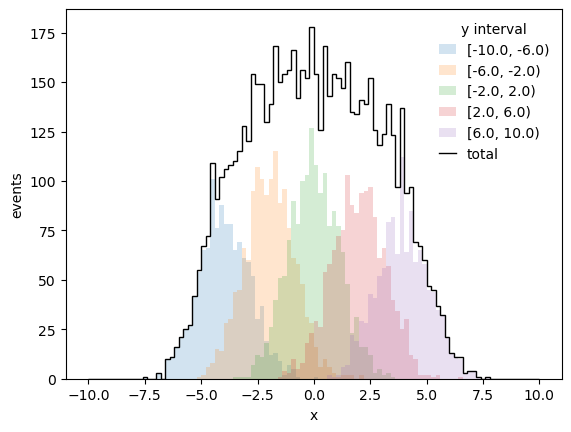

In [6]:
ax_x = bh.axis.Regular(100, -10, 10)
ax_y = bh.axis.Regular(5, -10, 10)
h = bh.Histogram(ax_x, ax_y)
h.fill(x, y)
for i, (a, b) in enumerate(ax_y):
    plt.stairs(h.values()[:,i], ax_x.edges, label=f"[{a}, {b})",
               fill=True, alpha=0.2)
h1 = h[:, sum]
plt.stairs(h1.values(), ax_x.edges, color="k", label="total")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(title="y interval", frameon=False, handlelength=1.2);

In [7]:
def model(xy, a, b, sigma):
    x, y = xy
    mu = a + b * y
    # cannot use norm.pdf from numba_stats here, because it is not vectorized in mu
    return norm.pdf(x, mu, sigma)

nll = UnbinnedNLL((x, y), model)

m = Minuit(nll, 0.0, 0.0, 2.0)
m.limits["sigma"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.93e+04                   │              Nfcn = 130              │
│ EDM = 2.25e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │  -0.010   │   0.012   │            │            │         │         │       │
│ 1 │ b     │  0.4993   │  0.0022   │            │            │         │         │       │
│ 2 │ sigma │   0.986   │   0.008   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        a        b    sigma │
├───────┼────────────────────────────┤
│     a │ 0.000142 1.31e-08 5.73e-08 │
│     b │ 1.31e-08 4.76e-06 1.02e-08 │
│ sigma │ 5.73e-08 1.02e-08 7.08e-05 │
└───────┴────────────────────────────┘

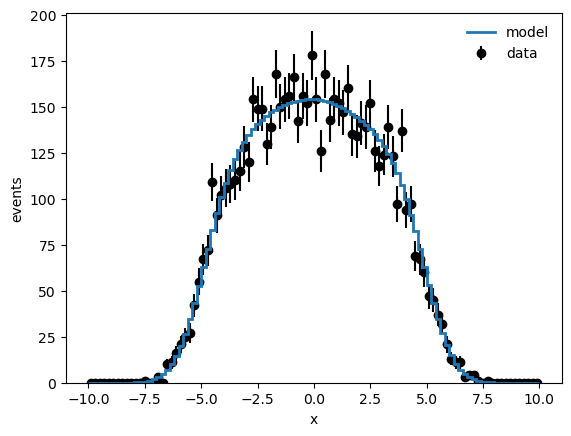

In [8]:
# construct model representation for comparison with data histogram
a, b, sigma = m.values

# get expected content per bin from cdf, sum over the individual cdfs
v = np.diff(np.sum(norm.cdf(ax_x.edges[:,np.newaxis],
                            mu(y, a, b), sigma), axis=1))

plt.stairs(v, ax_x.edges, label="model", zorder=5, lw=2)
plt.errorbar(ax_x.centers, h1.values(), h1.variances() ** 0.5,
             fmt="ok", label="data")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False);

In [9]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from iminuit.util import describe
from matplotlib import pyplot as plt
import numpy as np
from numba_stats import norm

In [10]:

# generate two data sets which are fitted simultaneously
rng = np.random.default_rng(1)

width = 2.0
data1 = rng.normal(0, width, size=1000)
data2 = rng.normal(5, width, size=1000)

In [11]:
# use two pdfs with different names for non-shared parameters,
# so that they are fitted independently

def pdf1(x, μ_1, σ):
    return norm.pdf(x, μ_1, σ)

def pdf2(x, μ_2, σ):
    return norm.pdf(x, μ_2, σ)

# combine two log-likelihood functions by adding them
lh = UnbinnedNLL(data1, pdf1) + UnbinnedNLL(data2, pdf2)

print(f"{describe(lh)=}")

describe(lh)=['μ_1', 'σ', 'μ_2']


In [12]:
def plot(cost, xe, minuit, ax, **style):
    signature = describe(cost)
    data = cost.data

    values = minuit.values[signature]
    errors = minuit.errors[signature]

    cx = (xe[1:] + xe[:-1]) / 2

    ym = np.diff(norm.cdf(xe, *values)) * np.sum(w)
    t = []
    for n, v, e in zip(signature, values, errors):
        t.append(f"${n} = {v:.3f} ± {e:.3f}$")
    ax.plot(cx, ym, label="\n".join(t), **style)

In [13]:
m = Minuit(lh, μ_1=1, μ_2=2, σ=1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

hists = [np.histogram(lhi.data, bins=50) for lhi in lh]

# draw data and model with initial parameters
for lhi, (w, xe), axi in zip(lh, hists, ax):
    cx = (xe[1:] + xe[:-1]) / 2
    axi.errorbar(cx, w, np.sqrt(w), fmt="ok", capsize=0, zorder=0)
    plot(lhi, xe, m, axi, ls="--")

m.migrad()

# draw model with fitted parameters
for lhi, (w, xe), axi in zip(lh, hists, ax):
    plot(lhi, xe, m, axi)
    axi.legend()

m.interactive()

In [14]:
import numpy as np
from numba_stats import norm, expon
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL, ExtendedBinnedNLL
import joblib
from IPython.display import display

In [15]:
# sample size, change this to see how the results of the comparison change
n = 100_000
truth = np.array((1.0, 1.0, 1.0, 0.1, 1.0))

rng = np.random.default_rng(1)
s = rng.normal(truth[2], truth[3], size=int(n * truth[0]))
b = rng.exponential(truth[4], size=int(n * truth[1]))
pts = np.append(s, b)
pts = pts[(pts > 0) & (pts < 2)]

In [4]:
def fit(c):
    m = Minuit(c, s=1, b=1, mu=1, sigma=0.1, tau=1)
    m.limits["s", "b", "sigma", "tau"] = (0, None)
    m.limits["mu"] = (0, 2)
    m.migrad()
    assert m.valid
    return m

In [5]:
def density(x, s, b, mu, sigma, tau):
    xrange = (0, 2)
    s1 = s * n * np.diff(norm.cdf(xrange, mu, sigma))
    b1 = b * n * np.diff(expon.cdf(xrange, 0, tau))
    return s1 + b1, (
        s * n * norm.pdf(x, mu, sigma) +
        b * n * expon.pdf(x, 0, tau)
    )

m = fit(ExtendedUnbinnedNLL(pts, density))
par_names = [m.params[i].name for i in range(m.npar)]
results = {np.inf: (np.array(m.values), np.array(m.errors), m.fmin.time)}
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.08e+06                  │              Nfcn = 120              │
│ EDM = 1.25e-05 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │   0.995   │   0.004   │            │            │    0    │         │       │
│ 1 │ b     │   1.008   │   0.005   │            │            │    0    │         │       │
│ 2 │ mu    │ 999.3e-3  │  0.4e-3   │            │            │    0    │    2    │       │
│ 3 │ sigma │ 99.21e-3  │  0.34e-3  │            │            │    0    │         │       │
│ 4 │ tau   │   1.002   │   0.007   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │  1.32e-05 -4.96e-06 -3.97e-08  2.99e-07 -3.97e-06 │
│     b │ -4.96e-06  2.36e-05  8.26e-10  -4.6e-07  1.96e-05 │
│    mu │ -3.97e-08  8.26e-10  1.46e-07 -5.62e-09 -1.42e-07 │
│ sigma │  2.99e-07  -4.6e-07 -5.62e-09  1.12e-07 -3.62e-07 │
│   tau │ -3.97e-06  1.96e-05 -1.42e-07 -3.62e-07  4.76e-05 │
└───────┴───────────────────────────────────────────────────┘

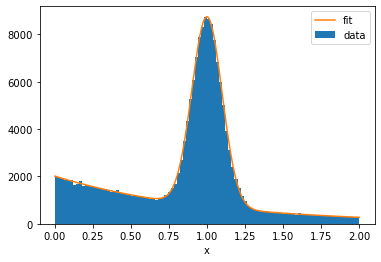

In [6]:
xm = np.linspace(np.min(pts), np.max(pts), 1000)
_, ym = density(xm, *m.values)
plt.hist(pts, bins=100, range=(0, 2), label="data")
dx = 2 / 100
plt.plot(xm, ym * dx, label="fit")
plt.legend()
plt.xlabel("x");

In [9]:
ym

array([100613.37105141, 100412.50774748, 100212.0454446 , 100011.9833422 ,
        99812.32064134,  99613.05654465,  99414.19025637,  99215.72098232,
        99017.6479299 ,  98819.9703081 ,  98622.68732749,  98425.7982002 ,
        98229.30213997,  98033.19836206,  97837.48608335,  97642.16452223,
        97447.23289869,  97252.69043426,  97058.53635202,  96864.76987663,
        96671.39023425,  96478.39665263,  96285.78836104,  96093.56459028,
        95901.72457271,  95710.26754221,  95519.19273418,  95328.49938557,
        95138.18673482,  94948.25402192,  94758.70048837,  94569.52537717,
        94380.72793286,  94192.30740145,  94004.26303049,  93816.59406901,
        93629.29976755,  93442.37937815,  93255.83215433,  93069.6573511 ,
        92883.85422498,  92698.42203394,  92513.36003746,  92328.6674965 ,
        92144.34367346,  91960.38783225,  91776.79923823,  91593.57715823,
        91410.72086056,  91228.22961496,  91046.10269266,  90864.33936631,
        90682.93891005,  

# Extended unbinned fit

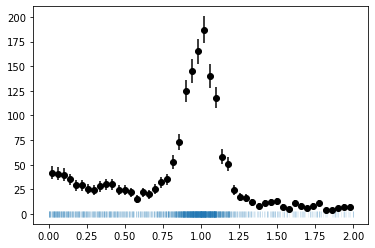

In [2]:
xr = (0, 2)  # xrange

rng = np.random.default_rng(1)

xdata = rng.normal(1, 0.1, size=1000)
ydata = rng.exponential(size=len(xdata))
xmix = np.append(xdata, ydata)
xmix = xmix[(xr[0] < xmix) & (xmix < xr[1])]

n, xe = np.histogram(xmix, bins=50, range=xr)
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)

plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.plot(xmix, np.zeros_like(xmix), "|", alpha=0.1);

In [3]:
n, xe = np.histogram(xmix, bins=50, range=xr)

In [4]:
cx

array([0.02, 0.06, 0.1 , 0.14, 0.18, 0.22, 0.26, 0.3 , 0.34, 0.38, 0.42,
       0.46, 0.5 , 0.54, 0.58, 0.62, 0.66, 0.7 , 0.74, 0.78, 0.82, 0.86,
       0.9 , 0.94, 0.98, 1.02, 1.06, 1.1 , 1.14, 1.18, 1.22, 1.26, 1.3 ,
       1.34, 1.38, 1.42, 1.46, 1.5 , 1.54, 1.58, 1.62, 1.66, 1.7 , 1.74,
       1.78, 1.82, 1.86, 1.9 , 1.94, 1.98])

In [5]:
xmix

array([1.03455842, 1.08216181, 1.03304371, ..., 0.30078182, 0.4005179 ,
       0.37044758])

In [6]:
dx

array([0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04])

In [15]:
from numba_stats import truncnorm, truncexpon, norm, expon

In [16]:
def density(x, s, b, mu, sigma, tau):
    return s + b, (s * truncnorm.pdf(x, *xr, mu, sigma) +
        b * truncexpon.pdf(x, *xr, 0, tau))

c = cost.ExtendedUnbinnedNLL(xmix, density)

m = Minuit(c, s=300, b=1500, mu=0, sigma=0.2, tau=2)
m.limits["s", "b", "sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.388e+04                 │              Nfcn = 362              │
│ EDM = 2.8e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  1.01e3   │  0.04e3   │            │            │    0    │         │       │
│ 1 │ b     │    872    │    35     │            │            │    0    │         │       │
│ 2 │ mu    │   0.996   │   0.004   │            │            │         │         │       │
│ 3 │ sigma │  0.1006   │  0.0035   │            │            │    0    │         │       │
│ 4 │ tau   │   1.05    │   0.08    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │  1.36e+03      -351  -0.00574    0.0355     -0.44 │
│     b │      -351  1.22e+03   0.00574   -0.0355      0.44 │
│    mu │  -0.00574   0.00574   1.5e-05 -9.28e-07 -1.53e-05 │
│ sigma │    0.0355   -0.0355 -9.28e-07  1.25e-05 -4.29e-05 │
│   tau │     -0.44      0.44 -1.53e-05 -4.29e-05   0.00568 │
└───────┴───────────────────────────────────────────────────┘

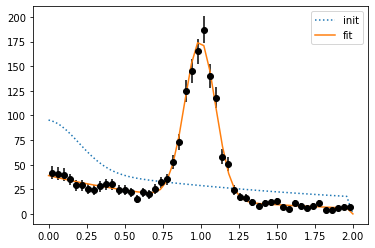

In [34]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(*xr)
plt.plot(xm, density(xm, *[p.value for p in m.init_params])[1] * dx[0],
         ls=":", label="init")
plt.plot(xm, density(xm, *m.values)[1] * dx[0], label="fit")
plt.legend();

In [18]:
xe

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
       0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
       1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
       1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  ])

In [19]:
dx

array([0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04])

In [24]:
print(*[p.value for p in m.init_params])

300.0 1500.0 0.0 0.2 2.0


In [33]:
np.linspace(*xr)

array([0.        , 0.04081633, 0.08163265, 0.12244898, 0.16326531,
       0.20408163, 0.24489796, 0.28571429, 0.32653061, 0.36734694,
       0.40816327, 0.44897959, 0.48979592, 0.53061224, 0.57142857,
       0.6122449 , 0.65306122, 0.69387755, 0.73469388, 0.7755102 ,
       0.81632653, 0.85714286, 0.89795918, 0.93877551, 0.97959184,
       1.02040816, 1.06122449, 1.10204082, 1.14285714, 1.18367347,
       1.2244898 , 1.26530612, 1.30612245, 1.34693878, 1.3877551 ,
       1.42857143, 1.46938776, 1.51020408, 1.55102041, 1.59183673,
       1.63265306, 1.67346939, 1.71428571, 1.75510204, 1.79591837,
       1.83673469, 1.87755102, 1.91836735, 1.95918367, 2.        ])

In [25]:
 m.init_params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,s,300,3,,,0,,
1,b,1.500e3,0.015e3,,,0,,
2,mu,0.0,0.1,,,,,
3,sigma,0.200,0.002,,,0,,
4,tau,2.00,0.02,,,0,,


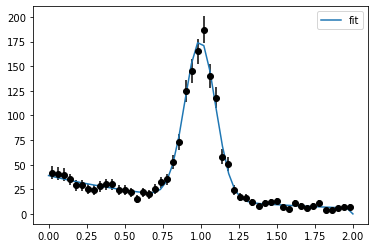

In [31]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(*xr)
# plt.plot(xm, density(xm, *[p.value for p in m.init_params])[1] ,
#          ls=":", label="init")
# plt.plot(xm, density(xm, *m.values)[1], label="fit")
plt.plot(xm, density(xm, *m.values)[1] * dx[0], label="fit")
plt.legend();

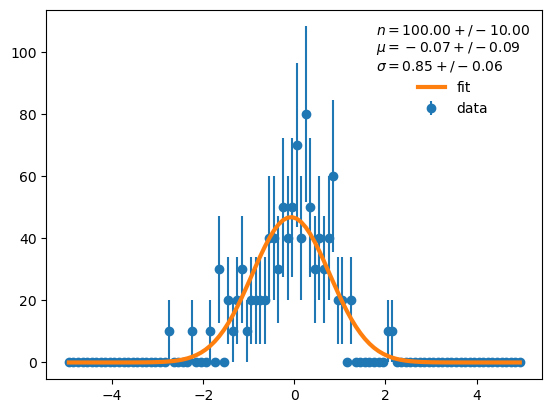

In [16]:
import numpy as np
from numba_stats import norm
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
import matplotlib.pyplot as plt

# generate toy sample
rng = np.random.default_rng(1)
x = rng.normal(size=100)

# bin it
w, xe = np.histogram(x, bins=100, range=(-5, 5))
# compute bin-wise density estimates
werr = w ** 0.5
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)
d = w / dx
derr = werr / dx


# define model and cost function
def model(x, par):
    return par[0], par[0] * norm.pdf(x, par[1], par[2])

cost = ExtendedUnbinnedNLL(x, model)

# fit the model
m = Minuit(cost, (1, 0, 1))
m.migrad()
m.hesse()

# plot everything
plt.errorbar(cx, d, derr, fmt="o", label="data", zorder=0)

plt.plot(cx, model(cx, m.values)[1], lw=3,
         label="fit")
plt.legend(frameon=False,
           title=f"$n = {m.values[0]:.2f} +/- {m.errors[0]:.2f}$\n"
                 f"$\mu = {m.values[1]:.2f} +/- {m.errors[1]:.2f}$\n"
                 f"$\sigma = {m.values[2]:.2f} +/- {m.errors[2]:.2f}$");

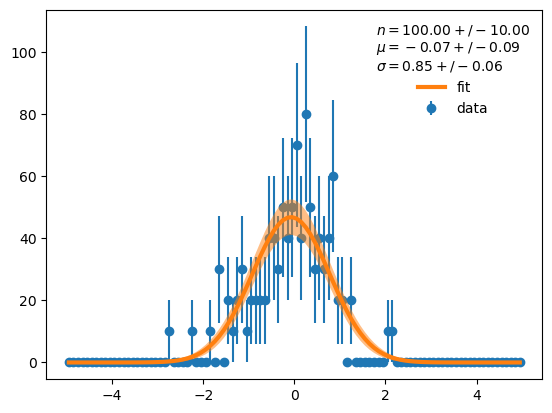

In [18]:
from jacobi import propagate

# run error propagation
y, ycov = propagate(lambda p: model(cx, p)[1], m.values, m.covariance)

# plot everything
plt.errorbar(cx, d, derr, fmt="o", label="data", zorder=0)

plt.plot(cx, y, lw=3, label="fit")

# draw 1 sigma error band
yerr_prop = np.diag(ycov) ** 0.5
plt.fill_between(cx, y - yerr_prop, y + yerr_prop, facecolor="C1", alpha=0.5)

plt.legend(frameon=False,
           title=f"$n = {m.values[0]:.2f} +/- {m.errors[0]:.2f}$\n"
                 f"$\mu = {m.values[1]:.2f} +/- {m.errors[1]:.2f}$\n"
                 f"$\sigma = {m.values[2]:.2f} +/- {m.errors[2]:.2f}$");